<a href="https://colab.research.google.com/github/Shonn-Li/CS484-final-project/blob/main/CS484-ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 6 (+,++): "CAM and object detection". First, you should implement some standard method for CAM for some (simple) classification network trained on image-level tags. You should also obtain object detection (spacial localization of the object approximate "center"). You should apply your approach to one specific object type (e.g. faces, or anything else). Training should be done on image-level tags (e.g. face, no face). You can come up with your specialized dataset, but feel free to use subsets of standard data. You can also test the ideas on real datasets where label noise is presemt

In [14]:
# libraries
import random
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from typing import OrderedDict
from torch.utils.data import DataLoader, random_split, Subset, Dataset, ConcatDataset
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
%pip install d2l==1.0.3

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()


### Step 1: Prepare data
We will use CIFAR10 dataset.

In [17]:
caltech256_all = datasets.Caltech256(root="./data", download=True, transform=transforms.ToTensor())

def indexFilter(target, dataset):
  target_indices = []
  remains = []
  for i in range(len(dataset)):
    img, label = dataset[i]
    if img.size(0) == 3 and label == target:
      target_indices.append(i)
    elif img.size(0) == 3:
      remains.append(i)
  return target_indices, remains


# class for applying transformations
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None, target=None):
        self.dataset = dataset
        self.transform = transform
        self.target = target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
          image = self.transform(image)
        if self.target:
          return image, 1 if (label == self.target) else 0
        return image, label

# img transform
norms = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
trainTrans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(*norms)
])



1183006720it [00:15, 74464294.16it/s]


Extracting ./data/caltech256/256_ObjectCategories.tar to ./data/caltech256


In [18]:
# get target class data
target_class = 55 #dog # define the class we want to recognize
target_indices, remains = indexFilter(target_class, caltech256_all)
target_dataset = Subset(caltech256_all, target_indices)
print(f"number of targets: {len(target_dataset)}")

# draw samples from the remaining data
subset_size = len(target_dataset) * 5
random_indices = random.sample(remains, subset_size)
remain_dataset = Subset(caltech256_all, random_indices)

# combine target and remain, redefine labels
caltech256_filtered = ConcatDataset([target_dataset, remain_dataset])
caltech256 = TransformDataset(caltech256_filtered, transform=trainTrans, target=target_class)


number of targets: 102


In [19]:
print(f"processed dataset size: {len(caltech256)}")

processed dataset size: 612


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image label: 1
torch.Size([3, 224, 224])


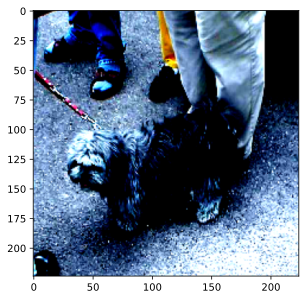

In [20]:
img, label = caltech256[50]
print(f"image label: {label}")
plt.figure()
plt.imshow(torch.permute(img, (1, 2, 0)))
print(img.shape)

### Step 2: Define Network

In [21]:
class MyModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()

        # extract vgg19 feature layer
        vgg19 = models.vgg19(weights='DEFAULT')
        self.vgg19Feat = vgg19.features[:28] # result in 512x14x14
        for param in self.vgg19Feat.parameters():
            param.requires_grad = False

        # additional conv layer & average pooling
        self.process = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('pool', nn.AdaptiveAvgPool2d((1, 1))),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(1024, num_classes))
        ]))


    def forward(self, x):
        x = self.vgg19Feat(x)
        x = self.process(x)

        return x

### Step 3: Training

In [22]:
# training function
def trainLoop(model, criterion, optimizer, dataloader, max_epoch):
    losses = []
    accuracies = []
    model.train()
    for epoch in range(max_epoch):
        epoch_loss = 0
        epoch_correct = 0
        dataCount = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(dim=1)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            dataCount += images.size(0)

            epoch_correct += torch.eq(preds, labels).sum().item()

            loss.backward()
            optimizer.step()

        # gather loss
        epoch_avg_loss = epoch_loss / dataCount
        epoch_acc = epoch_correct / dataCount
        losses.append(epoch_avg_loss)
        accuracies.append(epoch_acc)
        print(f"Epoch {epoch + 1}， loss is {epoch_avg_loss:.3f}, accuracy is {epoch_acc:.3f}")

    return losses, accuracies

In [23]:
# split data into test and training sets
train_size = int(0.8 * len(caltech256))
test_size = len(caltech256) - train_size
train_dataset, test_dataset = random_split(caltech256, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
# perform training
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss()
parameters = [{'params': model.process.parameters()}]
optimizer = optim.Adam(parameters, lr=0.001)
max_epoch=5
train_loss, train_acc = trainLoop(model, criterion, optimizer, train_loader,  max_epoch)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:39<00:00, 14.4MB/s]


Epoch 1， loss is 0.078, accuracy is 0.861
Epoch 2， loss is 0.007, accuracy is 0.920
Epoch 3， loss is 0.010, accuracy is 0.959
Epoch 4， loss is 0.005, accuracy is 0.961
Epoch 5， loss is 0.004, accuracy is 0.963


### Step 4: Create CAM

In [25]:
class CAM(nn.Module):
  def __init__(self, model):
    super(CAM, self).__init__()
    self.weights = list(model.process.linear.parameters())[0]
    self.feature_layers = nn.Sequential(model.vgg19Feat, model.process.conv)

    for params in self.feature_layers.parameters():
      params.requires_grad = False

  def forward(self, imgs, categories):
    feat_weights = self.weights[categories].unsqueeze(-1).unsqueeze(-1)
    feat_maps= self.feature_layers(imgs)

    cam = torch.sum(feat_weights * feat_maps, dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, imgs.shape[2:], mode='bilinear', align_corners=False)

    cam = cam - cam.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
    cam = cam / cam.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]

    return cam




In [26]:
def createCAM(model, dataset, demoTransform, inputTransform, target=target_class,
              CustomTransform=TransformDataset, batch_size=32):
  camModel = CAM(model)
  inputData = CustomTransform(dataset, inputTransform)
  demoData = CustomTransform(dataset, demoTransform)
  inputLoader = DataLoader(inputData, batch_size, shuffle=False)
  demoLoader = DataLoader(demoData, batch_size, shuffle=False)

  heatmaps = []
  demoImages = []

  with torch.no_grad():
    for (inputImgs, labels), (demoImgs, _) in zip(inputLoader, demoLoader):
      heatImg = camModel(inputImgs.to(device), labels.to(device))

      heatmaps.append(heatImg.cpu())
      demoImages.append(demoImgs)

    resultHeatMaps = torch.cat(heatmaps, dim=0)
    resultDemoImages = torch.cat(demoImages, dim=0)

    return resultHeatMaps, resultDemoImages



In [27]:
demoTrans = transforms.Compose(
    [transforms.Resize((224, 224))]
)
inputTrans = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Normalize(*norms)]
)
indicies = [i for i in range(40, 50, 1)]
caltech256_sub = Subset(caltech256, indicies)
heatMaps, oriImgs = createCAM(model, caltech256_sub, demoTrans, inputTrans)

In [28]:
heatMaps.shape

torch.Size([10, 1, 224, 224])

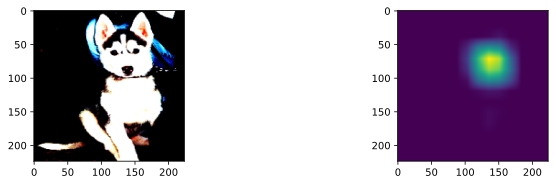

In [29]:
idx = 5
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(oriImgs[idx].permute(1, 2, 0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(heatMaps[idx].permute(1, 2, 0))

### TODO
- Write function to generate heat map for correctly identified picture
- Implement "object localization"


### Step 5: create single shot multibox detection model (SSD)

We will slightly modify the SSD model learned from [chapter 14.7 of Dive into Deep Learning](https://d2l.ai/chapter_computer-vision/ssd.html)

The overall structure of SSD is shown in the picture (from Dive into Deep Learning). We will replace the base network with the feature layers of VGG19, which is also used to generate heatmap.

In [36]:
### dependency
!pip install d2l
!pip install fiftyone

%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (set

In [31]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

def forward(x, block):
    return block(x)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)



In [32]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

net = TinySSD(num_classes=1)

In [33]:
### Sample excution
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [34]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

read 1000 training examples
read 100 validation examples


In [38]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load COCO 2017 train split, filtered to include only images of dogs
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=["dog"],
    max_samples=2000  # Increase or remove this limit as needed
)

# Visualize the dataset in the FiftyOne App (optional)
session = fo.launch_app(dataset)


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading 2000 images


 100% |████████████████| 2000/2000 [20.4m elapsed, 0s remaining, 1.6 images/s]      


INFO:eta.core.utils: 100% |████████████████| 2000/2000 [20.4m elapsed, 0s remaining, 1.6 images/s]      


Writing annotations for 2000 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 2000 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |███████████████| 2000/2000 [11.8s elapsed, 0s remaining, 142.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 2000/2000 [11.8s elapsed, 0s remaining, 142.6 samples/s]      


Dataset 'coco-2017-train-2000' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-train-2000' created


In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

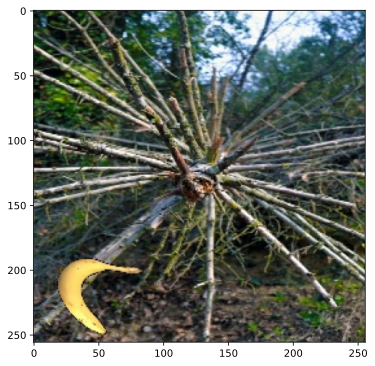

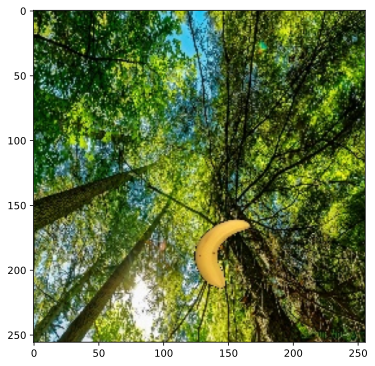

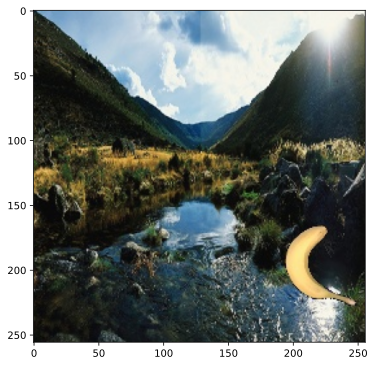

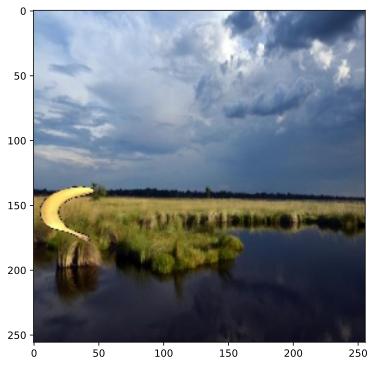

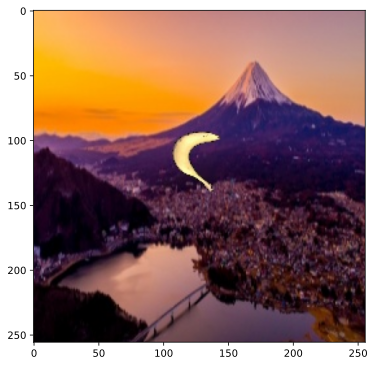

In [45]:
#  Iterate over the dataset
# Counter to keep track of the number of samples
counter = 0
for features, targets in train_iter:
    # Iterate over each sample in the batch
    for i in range(len(features)):
        print(f"Sample {counter + 1}:")
        print("Feature (Image):", features[i])
        print("Target (Annotation):", targets[i])
        print("\n")
        counter += 1

        # Break the loop after printing 50 samples
        if counter >= 5:
            break

    # Break the outer loop as well
    if counter >= 5:
        break

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image(img_tensor, annotation):
    # Convert tensor to numpy array and normalize
    img = img_tensor.permute(1, 2, 0).numpy()

    # Create a new figure with a specified size
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img.astype('uint8'))

    # Add the bounding box
    # Annotation format: [label, x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = annotation[0][1:] * img_tensor.shape[1]
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.show()

# Assuming 'features' and 'targets' are from your data loader
# features, targets = train_iter
for i in range(5):
    show_image(features[i], targets[i])


Result

In [ ]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)